In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import set_config
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import root_mean_squared_log_error as rmsle
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import StackingRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
import xgboost as xgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import seaborn as sns

In [2]:
train = pd.read_csv("train_comp.csv")
test = pd.read_csv("test_comp.csv")
# sample = pd.read_csv("sample_submission.csv")

train.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,36,189,82,26,101,41.0,150
1,female,64,163,60,8,85,39.7,34
2,female,51,161,64,7,84,39.8,29
3,male,20,192,90,25,105,40.7,140
4,female,38,166,61,25,102,40.6,146


In [3]:
numerical_features = ["Age","Height","Weight","Duration","Heart_Rate","Body_Temp"]

def add_feats(df, numerical_features):
    ''''''''''
    Inputs: dataframe df
    Output: the modified dataframe with cross terms, BMI, id+calories removed, and sex as categorical variable
    '''''''''
    df_new = df.copy()

    features = df_new.columns

    if 'id' in features:
        df_new = df_new.drop(columns=['id'])
    
    if 'Calories' in features:
        df_new = df_new.drop(columns=['Calories'])
    
    
    df_new['Sex'] = df_new['Sex'].astype('category')

    df_new['BMI'] = df_new['Weight']/((df_new['Height']/100)**2)

    for i in range(len(numerical_features)):
        for j in range(i + 1, len(numerical_features)):  
            feature1 = numerical_features[i]
            feature2 = numerical_features[j]
            cross_term_name = f"{feature1}_x_{feature2}"
            df_new[cross_term_name] = df_new[feature1] * df_new[feature2]
            #cross_term_name = f"{feature1}_divided_{feature2}"
            #df_new[cross_term_name] = df_new[feature1] / df_new[feature2]

    return df_new

In [5]:
y = np.log1p(train['Calories'])

X = add_feats(train, numerical_features)
test_mod = add_feats(test, numerical_features)

X.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Age_x_Height,Age_x_Weight,...,Height_x_Weight,Height_x_Duration,Height_x_Heart_Rate,Height_x_Body_Temp,Weight_x_Duration,Weight_x_Heart_Rate,Weight_x_Body_Temp,Duration_x_Heart_Rate,Duration_x_Body_Temp,Heart_Rate_x_Body_Temp
0,male,36,189,82,26,101,41.0,22.955684,6804,2952,...,15498,4914,19089,7749.0,2132,8282,3362.0,2626,1066.0,4141.0
1,female,64,163,60,8,85,39.7,22.582709,10432,3840,...,9780,1304,13855,6471.1,480,5100,2382.0,680,317.6,3374.5
2,female,51,161,64,7,84,39.8,24.690405,8211,3264,...,10304,1127,13524,6407.8,448,5376,2547.2,588,278.6,3343.2
3,male,20,192,90,25,105,40.7,24.414062,3840,1800,...,17280,4800,20160,7814.4,2250,9450,3663.0,2625,1017.5,4273.5
4,female,38,166,61,25,102,40.6,22.136740,6308,2318,...,10126,4150,16932,6739.6,1525,6222,2476.6,2550,1015.0,4141.2


In [ ]:
# 1) Load and split data
y = np.log1p(train['Calories'])
X = add_feats(train, numerical_features)
test_mod = add_feats(test, numerical_features)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=724
)

# 2) Define base (level-0) regressors
# all parameters are selected in their corresponding files

xgb_reg = XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    reg_lambda=3.3114e-07,
    reg_alpha=0.3825,
    subsample=0.8,
    colsample_bytree=0.3904,
    max_depth=8,
    min_child_weight=5,
    learning_rate=0.01,
    gamma=4.3686e-05,
    grow_policy='depthwise',
    n_estimators=1331,
    verbosity=0,
    random_state=724,
    eval_metric='rmse',
    enable_categorical=True
)

lgbm_reg = LGBMRegressor(
    learning_rate=0.005,
    # subsample=0.8,
    reg_alpha=3.8869978375166585e-08,  # same as lambda_l1
    reg_lambda=0.0010162754716993953, # same as lambda_l2
    num_leaves=236,
    feature_fraction=0.4461813407494733,
    bagging_fraction=0.9450298735003453, # same as subsample
    bagging_freq=1,
    objective='regression',
    boosting_type='gbdt',
    n_estimators=2106,
    verbose=-1,
)

cb_reg = CatBoostRegressor(
    iterations=1722,
    depth=12,
    learning_rate=0.015,
    l2_leaf_reg=0.00011954668586223026,
    bagging_temperature=4.475008023561076e-05,
    border_count=133,
    grow_policy="SymmetricTree",
    #task_type='GPU',
    eval_metric='RMSE',
    loss_function='RMSE',
    random_state=724,
    verbose=0,
    # early_stopping_rounds=40,
    # use_best_model=True,
    cat_features=['Sex']
)

base_estimators = [
    ('xgb', xgb_reg),
    ('lgbm', lgbm_reg),
    ('cb', cb_reg)
]

# 3) Build the stacking regressor
stack = StackingRegressor(
    estimators=base_estimators,
    final_estimator=RidgeCV(alphas=[0.01, 0.1, 1.0, 10]),  # meta-learner
    cv=3,                        # folds for out-of-fold predictions
    n_jobs=-1,                   # parallelize training
    passthrough=False            # if True, original features are concatenated with base preds
)

# 4) Train and evaluate
stack.fit(X_train, y_train)
y_pred_train = stack.predict(X_train)
y_pred_test = stack.predict(X_test)
error_train = rmse(y_train, y_pred_train)
error_test = rmse(y_test, y_pred_test)

print(f"StackingRegressor + RidgeCV RMSE (train): {error_train}")
print(f"StackingRegressor + RidgeCV RMSE (test): {error_test}")



# private score 0.05881, public 0.05714, 715/4318 ensemble_prediction_3.csv

# make the submission file!
pred = stack.predict(test_mod)

submission = pd.DataFrame()

submission['id'] = np.arange(len(test))+750000
submission['Calories'] = np.expm1(pred)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1
submission.loc[submission['Calories'] > 320, 'Calories'] = 300

submission.to_csv("ensemble_prediction_3.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

StackingRegressor + RidgeCV RMSE (train): 0.05361999244701577
StackingRegressor + RidgeCV RMSE (test): 0.05928178224377704
       id    Calories
0  750000   27.540354
1  750001  108.249230
2  750002   87.560235
3  750003  126.021790
4  750004   76.153791

count    250000.000000
mean         88.181075
std          62.274795
min           0.999609
25%          34.014687
50%          76.446186
75%         135.366752
max         295.274778
Name: Calories, dtype: float64


In [5]:
print(stack.final_estimator_.coef_)

[0.2750209  0.1667896  0.55831488]


In [ ]:
# 1) Load and split data
y = np.log1p(train['Calories'])
X = add_feats(train, numerical_features)
test_mod = add_feats(test, numerical_features)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=724
)

# 2) Define base (level-0) regressors
# all parameters are selected in their corresponding files

xgb_reg = XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    reg_lambda=3.3114e-07,
    reg_alpha=0.3825,
    subsample=0.8,
    colsample_bytree=0.3904,
    max_depth=8,
    min_child_weight=5,
    learning_rate=0.01,
    gamma=4.3686e-05,
    grow_policy='depthwise',
    n_estimators=1331,
    verbosity=0,
    random_state=724,
    eval_metric='rmse',
    enable_categorical=True
)


lgbm_reg = LGBMRegressor(
    learning_rate=0.015,
    subsample=0.8,
    reg_alpha=0.0003012202397393636,
    reg_lambda=3.139197133972411e-06,
    num_leaves=247,
    feature_fraction=0.7097639119363803,
    bagging_fraction=0.9460887091498462,
    bagging_freq=3,
    objective='regression',
    boosting_type='gbdt',
    n_estimators=616,
    verbose=-1,
)

cb_reg = CatBoostRegressor(
    iterations=1251,
    depth=12,
    learning_rate=0.02,
    l2_leaf_reg=0.0008937117069387631,
    bagging_temperature=0.00013382380596995918,
    border_count=177,
    grow_policy="SymmetricTree",
    #task_type='GPU',
    eval_metric='RMSE',
    loss_function='RMSE',
    random_state=724,
    verbose=0,
    # early_stopping_rounds=40,
    # use_best_model=True,
    cat_features=['Sex']
)

base_estimators = [
    ('xgb', xgb_reg),
    ('lgbm', lgbm_reg),
    ('cb', cb_reg)
]

# 3) Build the stacking regressor
stack = StackingRegressor(
    estimators=base_estimators,
    final_estimator=RidgeCV(alphas=[0.01, 0.1, 1.0, 10]),  # meta-learner
    cv=3,                        # folds for out-of-fold predictions
    n_jobs=-1,                   # parallelize training
    passthrough=False            # if True, original features are concatenated with base preds
)

# 4) Train and evaluate
stack.fit(X_train, y_train)
y_pred_train = stack.predict(X_train)
y_pred_test = stack.predict(X_test)
error_train = rmse(y_train, y_pred_train)
error_test = rmse(y_test, y_pred_test)

print(f"StackingRegressor + RidgeCV RMSE (train): {error_train}")
print(f"StackingRegressor + RidgeCV RMSE (test): {error_test}")



# private score 0.05878, public 0.05719, 655/4318 ensemble_prediction_2.csv

# make the submission file!
pred = stack.predict(test_mod)

submission = pd.DataFrame()

submission['id'] = np.arange(len(test))+750000
submission['Calories'] = np.expm1(pred)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1
submission.loc[submission['Calories'] > 320, 'Calories'] = 300

submission.to_csv("ensemble_prediction_2.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

StackingRegressor + RidgeCV RMSE (train): 0.05367702747422736
StackingRegressor + RidgeCV RMSE (test): 0.05922129245988407


In [26]:
print(stack.final_estimator_.alpha_)
print(stack.final_estimator_.coef_)

10.0
[0.28368365 0.22512217 0.49133366]


In [ ]:
# private score 0.05878, public 0.05719, 655/4318

# make the submission file!
pred = stack.predict(test_mod)

submission = pd.DataFrame()

submission['id'] = np.arange(len(test))+750000
submission['Calories'] = np.expm1(pred)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1
submission.loc[submission['Calories'] > 320, 'Calories'] = 300

submission.to_csv("ensemble_prediction_2.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

       id    Calories
0  750000   27.507830
1  750001  108.202196
2  750002   87.082541
3  750003  126.224012
4  750004   76.120066

count    250000.000000
mean         88.180101
std          62.273105
min           1.003544
25%          34.014314
50%          76.430988
75%         135.382095
max         294.857532
Name: Calories, dtype: float64


Get the best CatBoost and LightGBM models!

0.052568122904020284


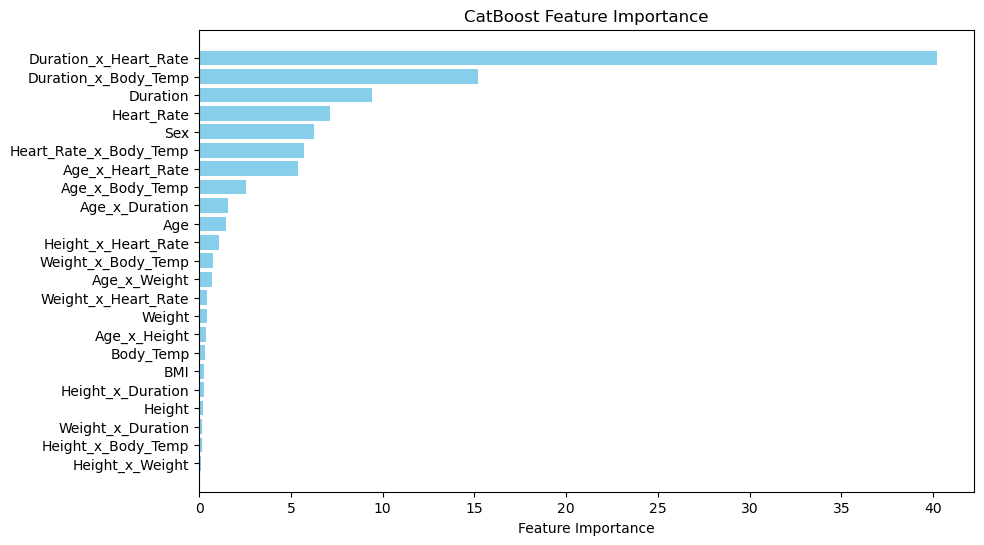

In [6]:
# Kaggle score 0.05769, cb_prediction_3.csv, iterations 1500, learning rate 0.05, early_stopping_rounds 50, depth 16

num_indices = 600000

train_index = np.random.choice(X.index, size=num_indices, replace=False)
test_index = list(set(np.arange(len(X))) - set(train_index))


X_train, X_test = X.loc[train_index], X.loc[test_index]
y_train, y_test = y.loc[train_index], y.loc[test_index]

# Define parameters
params = {
    'iterations': 1500,
    'learning_rate': 0.05,
    'depth': 16,                 # max depth is 16
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'early_stopping_rounds': 50,
    #'subsample': ss,
    'task_type': 'GPU',
    'verbose': -1
}

# Train the model
model_cb = CatBoostRegressor(**params)
model_cb.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=0, cat_features=[0])

# Make predictions
test_pred_cb = model_cb.predict(X_train)

# Ensure non-negative predictions (important for RMSLE)
test_pred_cb[test_pred_cb < 0] = 1

print(rmse(test_pred_cb, y_train))


# Get feature importances
feature_importances = model_cb.get_feature_importance()

# Get feature names
feature_names = X_train.columns

# Sort feature importances and names
sorted_idx = feature_importances.argsort()
sorted_importances = feature_importances[sorted_idx]
sorted_names = feature_names[sorted_idx]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_names, sorted_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("CatBoost Feature Importance")
plt.show()

[LightGBM] [Info] Total Bins 4419
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 23
[LightGBM] [Info] Start training from score 4.142467
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[180]	valid_0's rmse: 0.0609668
0.053033401780336616


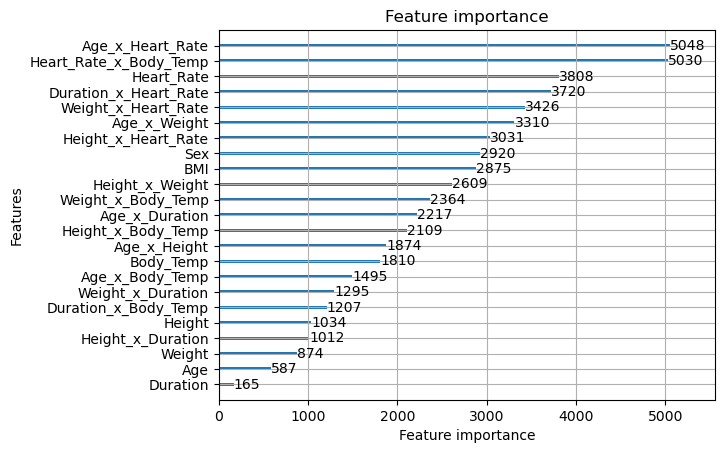

In [7]:
# Kaggle score 0.05826, lgb_prediction_20.csv, num_leaves 300, learning rate 0.05, subsample 0.75, boost rounds 200, stopping rounds 25

# num_indices = 600000

# train_index = np.random.choice(X.index, size=num_indices, replace=False)
# test_index = list(set(np.arange(len(X))) - set(train_index))


# X_train, X_test = X.loc[train_index], X.loc[test_index]
# y_train, y_test = y.loc[train_index], y.loc[test_index]

dtrain = lgb.Dataset(X_train, label=y_train)

# Define parameters
params = {
    'num_leaves': 300,
    'learning_rate': 0.05,
    'objective': 'regression',  # LightGBM doesn't have squaredlogerror directly
    'metric': 'rmse',           # We'll manually compute RMSLE
    'force_col_wise': True,     # Optional: can help with categorical support
    #'class_weight': 'balanced',
    'subsample': 0.75
}

# Train the model
model_LGBM = lgb.train(params, dtrain, num_boost_round=200, valid_sets=lgb.Dataset(X_test, label=y_test), callbacks=[lgb.early_stopping(stopping_rounds=25, verbose=True)])

# Make predictions
test_pred_LGBM = model_LGBM.predict(X_train)

# Ensure non-negative predictions (important for RMSLE)
test_pred_LGBM[test_pred_LGBM < 0] = 1

print(rmse(test_pred_LGBM, y_train))

lgb.plot_importance(model_LGBM)
plt.show()

In [9]:
# The weights of the model 0.01, 0.02, ..., 0.99 
testweights = np.arange(start=0.01, stop=1, step=0.01)

cb_pred = model_cb.predict(X_test)
LGBM_pred = model_LGBM.predict(X_test)

model_err = {}

for w in testweights:
    
    # y_pred = model.predict(X_test)
    # y_pred[y_pred <= 0] = 1
    # score = rmse(y_test, y_pred)
    # scores.append(score)

    model_err[f"weight_{w}"] = rmse(y_test, w*cb_pred + (1-w)*LGBM_pred)


# Find the key with the minimum value
min_key = min(model_err, key=model_err.get)

# Retrieve the minimum value
min_value = model_err[min_key]

# Print the result
print(f"The key with the minimum value is '{min_key}' with a value of {min_value}.")

print()

print("The training RMSE is", rmse(0.6*test_pred_cb + (1-0.6)*test_pred_LGBM, y_train))

The key with the minimum value is 'weight_0.6' with a value of 0.06027588487375037.

The training RMSE is 0.05224326659408018


In [10]:
# make the submission file!

weight = 0.6

pred = weight*model_cb.predict(test_mod) + (1-weight)*model_LGBM.predict(test_mod)

submission = pd.DataFrame()

submission['id'] = np.arange(len(test_mod))+750000
submission['Calories'] = np.expm1(pred)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1

submission.to_csv("ensemble_prediction_1.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

       id    Calories
0  750000   28.020179
1  750001  108.510229
2  750002   87.051454
3  750003  124.963863
4  750004   76.582390

count    250000.000000
mean         88.171280
std          62.260805
min           0.989280
25%          34.035158
50%          76.440136
75%         135.400078
max         295.640521
Name: Calories, dtype: float64
